# Lac Operon Biology
For an overview of the biology underlying this model, and a comparison to other models see [Santillan and Mackey. Quantitative approaches to the study of bistability int he lac operon of Escherichia coli, J. R. Soc Interface, 2008](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2008.0086.focus)

A brief description of the biology follows.

### Glucose
1. Glucose is transpored into the cell by the Glucose Permease protein and is simultaneously phosphorolated by the $EIIA_{glu}^{phosphate}$ enzyme which in turn loses its phosphate group.
2. The internal glucose-phosphate (or the internalization thereof) inhibits the synthesis of cAMP.
3. Glucose is metabolized by the cell to provide energy.

### Lactose
1. Lactose is transported into the cell by the lactose permease protein which is expressed from the lacY gene. This permease is inhibited by $EIIA_{glu}$. So, in the presence of glucose, most of this enzyme is not phosphorolated and lactose transport into the cell is inhibited.
2. Once in the cell, lactose is metabolized by $\beta$-Galactosidase which is expressed from the lacZ gene. One biproduct of a small portion of this metabolism is allolactose (inhibits lacR monomer) and a larger portion is glucose and galactose (later metabolized).

### Lac Operon
1. The lac Operon is a set of 3 lacR binding sites, one cAMP-CRP (consisting of a CRP-cAMP dimer) binding site, and a promoter (which binds to a $\sigma$ factor to recruit RNA-Polymerase). This operon controls three genes, LacY (Lactose Permease), lacZ ($\beta$-Galactosidase), and lacA (Galactoside acetyltransferase which is involved in downstream lactose metabolism).
2. The lacR repressor is a tetramer consisting of two homedimers. Each homeodimer can bind to a LacR binding site provided both monomers are active. Each monomer can be inhibited by binding to allolactose. Both the active and inhibited monomers can bind to form dimers and tetramers. Notice that a single tetramer can bind to two binding sites, inducing a bend in the DNA. Only the O1 LacR binding site, on its own, causes repression. However the simultaneous binding of the O1 and O2 or O1 and O3 complex cause even greater repression than just binding the O1 site.
3. The cAMP-CRP complex strongly activates the Lac Operon. Even without lacR, expression is fairly weak without cAMP-CRP activating the complex. The binding of this complex also increases the rate of a single lacR repressor binding to both the O3 and O1 simultaneously - meaning this activator can cooperatively help repression!

These biological facts can be simplified into the following simple schema:
* Internal Glucose Inhibits Lactose Internalization (indirectly through $EIIA_{glu}$)
* Internal Lactose Deactivates lacR (indirectly through allolactose)
* LacR deactivates the lac Operon 
* Internal glucose inhibits the lac Operon (indirectly through cAMP)
* The lac Operon produces $\beta$-Galactosidase and Lactose Permease
* Lactose Permease causes Lactose Internalization
* $\beta$-Galactosidase causes lactose to be metabolized

# Lac Operon Model
A comprehensive ODE model of the Lac Operon which is easily compatible with the CRN formalism can be found in [Wong et al. 1997](https://aiche.onlinelibrary.wiley.com/doi/full/10.1021/bp970003o). Unfortunately, this model does not include some of the more modern details described above because they were not known at the time. 

A more modern model of the Lac Operon can be found here: [Santillan et al. Origin of Bistability in the lac Operon, Biophysical Journal, 2007](https://www.sciencedirect.com/science/article/pii/S0006349507711839?via%3Dihub). This model includes all the features described above except for the different combinatorial conformations of the lacR repressor binding on the Operon. In [Santillan 2008](https://www.sciencedirect.com/science/article/pii/S0006349508705538?via%3Dihub), the previous model was extended to include these combinatorial states. This model was further extended to include artifical inducers in [Hernandez and Santillan, 2010](https://www.frontiersin.org/articles/10.3389/fphys.2010.00022/full). These models makes extensive use of products of hill functions to produce an ODE model based upon the probability of the Lac Operon being on and are not treated as fully stochastic models in this sense, despite superficially including probabilities.

Below is a modified version of the Santillan 2007 model, which is a good compromise between being comprehensive without excessive complexity. Modifications include explicitly considering internal glucose (technically glucose-phosphate) and allowing for treating external glucose and external lactose as dynamic variables instead of constants. Additionally, proteins species such as LacR and the Glucose Permease are modeled explicitly with production and degredation (so they can be placed in a single cell model). This model has also been recast as a CRN instead of a set of ODES.

### Species:
* Lactose: $L_{in}$ and $L_{ex}$
* Glucose: $G_{in}$ and $G_{ex}$
* Allolactose: $A \approx L_{in}$ following the analysis in [Santillan et al. 2007](https://www.sciencedirect.com/science/article/pii/S0006349507711839?via%3Dihub).
* Lac Operon: $O_{Lac}$
* mRNA: $M$
* $\beta$-Gal Monomer: $B_{mon}$
* $\beta$-Gal Tetramer: $B$
* Lactose Permease: $P_{lac}$ 
* Glucose Permease: $P_{glu}$ Constituitive Expression (And diluted by cell division)

## The stochastic and Deterministic Models will have the same Species

In [1]:
from biocrnpyler import *
import numpy as np
import pylab as plt

M = Species("M", material_type = "rna")
Bmon = Species("betaGal", material_type = "monomer")
B = Species("betaGal", material_type = "protein")
L_out = Species("Lactose", attributes = ["external"])
L_in = Species("Lactose", attributes = ["internal"])
L_consumed = Species("Lactose", attributes = ["consumed"])
G_out = Species('Glucose', attributes = ["external"])
G_in = Species('Glucose', attributes = ["internal"])
G_consumed = Species('Glucose', attributes = ["consumed"])
lacP = Species("Lactose_Permease", material_type = "protein")
BioMass = Species("Biomass")
OLac = Species("Lac_Operon", material_type = "dna")

#Create a list of all Species
species = [M, Bmon, B, L_out, L_in, G_out, G_in, lacP, OLac, BioMass]

## The deterministic model using a mixture of mass action and hill function propensities. Note units are in seconds and mM.

In [2]:
#reactions will be appended to this list
reactions_det = []

#Production of mRNA from the Lac Operon
#Propensity is an increasing hill function of internal lactose multiplied by a decreasing hill function of internal Glucose
Vtx = ParameterEntry( "Vtx", .18/60) #=.18 /min (k_M in Santillan 2007)
n_L = ParameterEntry("n_L", 4) #Due to tetramerization of LacR
K_L = ParameterEntry("K_L", 4.8155) #(mM) from 2.9*10**6molecules / average bacterium called K_A in Santillan 2007.
K_G = ParameterEntry("K_G", 2.5/1000) #(mM) from 2.5 uM Santillan 2007
n_G = ParameterEntry("n_G", 2) #Because CRP-cAMP binds as a dimer and glucose directly inhibits synthesis of cAMP
Olac_leak = ParameterEntry("k_leak", .05) #5% Leak
prop1_func = f"{str(OLac)}*(Vtx*(k_leak +{str(L_in)}^n_L/(K_L^n_L + {str(L_in)}^n_L)*(1/(1+({str(G_out)}/K_G)^n_G))))"
prop1 = GeneralPropensity(prop1_func, [L_in ,G_out, OLac], [Vtx, n_L, K_L, K_G, n_G, Olac_leak])
reactions_det.append(Reaction(inputs = [OLac], outputs = [OLac, M], propensity_type = prop1))

#translation of M
ktl_beta_gal = ParameterEntry("k_tl_beta_Gal", 9.4/60) #/sec from Wong et al.
reactions_det.append(Reaction.from_massaction([M], [M, Bmon], k_forward = ktl_beta_gal))
ktl_lacP = ParameterEntry("k_tl_lacP", 18.8/60) #/sec from Wong et al.
reactions_det.append(Reaction.from_massaction([M], [M, lacP], k_forward = ktl_lacP))

#Tetramerization of Beta Gal
kBgal_tet = ParameterEntry("BGal_tetramerization", 1000) #Assumed to be fast and irreversible for simplicity.
reactions_det.append(Reaction.from_massaction(4*[Bmon], [B], k_forward = kBgal_tet))

#Degredation of Lactose
#Lactose degredation to Allolactose and hydrolyzed to glucose and galactose, both processes catalyzed by beta-galatosidase. 
#We lump hydrolysis and allolactose conversion together into a single reaction as allolactose is not explicit in this model.
#Parameters taken from Wong et al.
# k_cat_lac-->allolactose = 8.46 * 10^3 / min
# k_cat_Lac (hydrolisis) = 9.54 * 10^3 / min
# k_cat (total) = k_cat_lac-->allolactose + k_cat_Lac = 18 * 10^3 / min
Vbgal= ParameterEntry("BGal_vmax", 18*10**3 / 60) ## k_cat (total) = k_cat_lac-->allolactose + k_cat_Lac = 18 * 10^3 / min from Wong et al.
Kbgal = ParameterEntry("Bgal_Kd", 1.4) #= 1.4*10-3 from K_M wong et al = 84310 molecules / bacteria
prop4 = ProportionalHillPositive(k = Vbgal, n = 1, s1 = L_in, d = B, K = Kbgal)
reactions_det.append(Reaction([L_in], [L_consumed], propensity_type = prop4))

#Importing Glucose
#assuming e coli is 70% water
#1 * 10**-4 mol Glu / (g dry cell mass min) (cell mass species / fL) (.3 fg dry cell mass / cell mass species) = .33 mM / (cell mass species min)
# = 18066 mM / (mM cell mass species  min) =  301 mol / (mol cell mass species s)
VgluP = ParameterEntry("GluPermease_vmax", 301) 
KgluP = ParameterEntry("GluPermease_Kd", 15/1000) #mM from Wong et all 1997
prop6 = ProportionalHillPositive(k = VgluP, n = 1, s1 = G_out, d = BioMass, K = KgluP)
reactions_det.append(Reaction([G_out], [G_in], propensity_type = prop6))

#Importing Lactose is limited by the amount of lacP and inhibited by glucose uptake rate
prop5_func = f"{str(lacP)}*LacPermease_vmax*{str(L_out)}/({str(L_out)} + LacPermease_Kd)*(1-phi_G*{str(G_out)}/(GluPermease_Kd+{str(G_out)}))"
phi_G = ParameterEntry("phi_G", .35) #Lactose Permease inhibition percent by glucose
VlacP = ParameterEntry("LacPermease_vmax", 2148/60) #(molecules / (permease sec)) = from Wong et al.
KlacP = ParameterEntry("LacPermease_Kd", .26) #(mM) from wong et al.
prop5 = GeneralPropensity(prop5_func, [L_out ,G_out, lacP], [KgluP, VlacP, KlacP, phi_G])
reactions_det.append(Reaction([L_out], [L_in], propensity_type = prop5))

#make Lactose transport reversible
VlacP_rev = ParameterEntry("LacPermease_reverse_vmax", 71.38/60) # mol / (mol permease sec) from Wong et al.
KlacP_rev = ParameterEntry("LacPermease_Kd", 14.62) #(mM) from Wong et al.
prop5r = ProportionalHillPositive(k = VlacP_rev, K = KlacP_rev, n = 1, d = lacP, s1 = L_in)
reactions_det.append(Reaction([L_in], [L_out], propensity_type = prop5r))

#degredation of mRNA
kD_mRNA = ParameterEntry("kdeg_mRNA", .47/60) #(/sec) from .47 / min in santillan 2007
reactions_det.append(Reaction.from_massaction([M], [], k_forward = kD_mRNA))

#protein degredation
kD_prot = ParameterEntry("kdeg_prot", .01/60) #(/sec) from Wong et al
reactions_det.append(Reaction.from_massaction([B], [], k_forward = kD_prot))
reactions_det.append(Reaction.from_massaction([lacP], [], k_forward = kD_prot))

#dilution (to be removed when cells grow and divide stochastically)
kDdil = ParameterEntry("k_dilution", .02/60) # (/sec) = 0.02 / min corresponds to a doubling time of 30 minutes

reactions_det.append(Reaction.from_massaction([lacP], [], k_forward = kDdil))
reactions_det.append(Reaction.from_massaction([Bmon], [], k_forward = kDdil))
reactions_det.append(Reaction.from_massaction([B], [], k_forward = kDdil))
reactions_det.append(Reaction.from_massaction([M], [], k_forward = kDdil))

In [3]:
#Create and Save the Deterministic model

#initial condition concentrations
#Units are mM
lacP0 = 0
Olac0 = 3.2*10**-6 #(mM) ~= 2 copies of Lac Operon per cell, variable D in Santillan 2007
G_out0 = 10 #in mM
L_out0 = 20 #in mM
biomass_param = 1.66 * 10**-3 #in units of mM femtogram species
initial_concentration_det = {lacP:lacP0, BioMass:biomass_param, OLac:Olac0, L_out: L_out0, G_out:G_out0}

CRN_det = ChemicalReactionNetwork(species, reactions_det, initial_concentration_dict = initial_concentration_det)
print(CRN_det.pretty_print())
CRN_det.write_sbml_file("LacOperon_deterministic.xml")

Species(N = 11) = {
Lactose(external) (@ 20),  Glucose(external) (@ 10),  Biomass (@ 0.00166),  dna[Lac_Operon] (@ 3.2e-06),  protein[betaGal] (@ 0),  monomer[betaGal] (@ 0),  rna[M] (@ 0),  protein[Lactose_Permease] (@ 0),  Lactose(consumed) (@ 0),  Lactose(internal) (@ 0),  Glucose(internal) (@ 0),  
}

Reactions (15) = [
0. dna[Lac_Operon] --> dna[Lac_Operon]+rna[M]
dna_Lac_Operon*(k_leak+(Vtx*Lactose_internal^n_L/(K_L^n_L + Lactose_internal^n_L)*(1/(1+(Glucose_external/K_G)^n_G))))
  Vtx=0.003
  n_L=4
  K_L=4.8155
  K_G=0.0025
  n_G=2
  k_leak=0.00015000000000000001

1. rna[M] --> rna[M]+monomer[betaGal]
 Kf=k_forward * rna_M
  k_forward=0.15666666666666668

2. rna[M] --> rna[M]+protein[Lactose_Permease]
 Kf=k_forward * rna_M
  k_forward=0.31333333333333335

3. 4monomer[betaGal] --> protein[betaGal]
 Kf=k_forward * monomer_betaGal^4
  k_forward=1000

4. Lactose(internal) --> Lactose(consumed)
 Kf = k protein[betaGal] Lactose(internal)^n / ( K^n + Lactose(internal)^n )
  k=300.0
  K

True

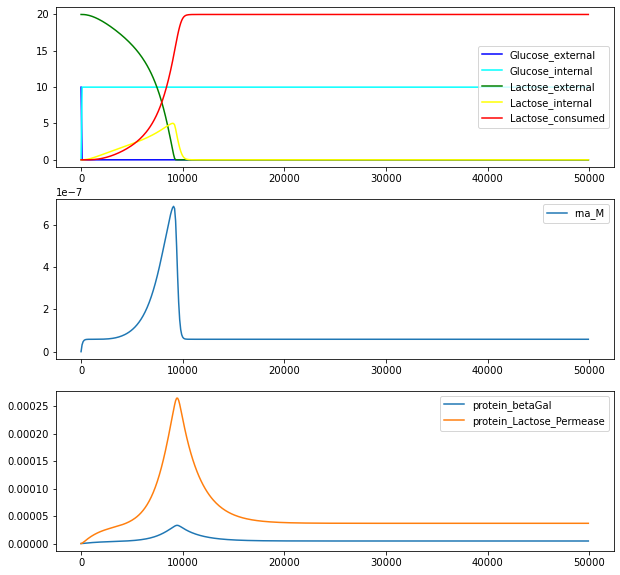

In [4]:
%matplotlib inline
timepoints = np.arange(0, 50000, 100)

#Initial condition requires a small amount of LacP
#x0 = {str(OLac):1, str(L_out):1000, str(G_out):2000, str(lacP):.01}

R = CRN_det.simulate_with_bioscrape_via_sbml(timepoints)

plt.figure(figsize = (10, 10))
plt.subplot(311)
plt.plot(timepoints, R[str(G_out)], label = str(G_out), color = "blue")
plt.plot(timepoints, R[str(G_in)], label = str(G_in), color = "cyan")
#plt.plot(timepoints, R[str(G_consumed)], label = str(G_consumed))
plt.plot(timepoints, R[str(L_out)], label = str(L_out), color = "green")
plt.plot(timepoints, R[str(L_in)], label = str(L_in), color = "yellow")
plt.plot(timepoints, R[str(L_consumed)], label = str(L_consumed), color = "red")
plt.legend()

plt.subplot(312)
plt.plot(timepoints, R[str(M)], label = str(M))
plt.legend()

plt.subplot(313)
plt.plot(timepoints, R[str(B)], label = str(B))
plt.plot(timepoints, R[str(lacP)], label = str(lacP))
plt.legend()

plt.show()

# Create the Stochastic Model

This model is the same as the deterministic model, but with different units (counts instead of molar concentrations) resulting in some parameters changing value. Additionally, the stochastic model does not have dilution reactions because dilution will ultimately be modeled via binomial partitioning of single cells upon division.

In [5]:
#reactions will be appended to this list
reactions_stoch = []

#Production of mRNA from the Lac Operon
#Propensity is an increasing hill function of internal lactose multiplied by a decreasing hill function of internal Glucose

Vtx = ParameterEntry( "Vtx", .18/60) #=.18 /min (k_M in Santillan 2007)
n_L = ParameterEntry("n_L", 4) #Due to tetramerization of LacR
K_L = ParameterEntry("K_L", 2.9*10**6) #from 2.9*10**6 molecules / average bacterium called K_A in Santillan 2007.
K_G = ParameterEntry("K_G", 1506) # from 2.5 uM Santillan 2007 converted to counts assuming V = 1fL
n_G = ParameterEntry("n_G", 2) #Because CRP-cAMP binds as a dimer and glucose directly inhibits synthesis of cAMP
Olac_leak = ParameterEntry("k_leak", .05) #5% Leak
prop1_func = f"{str(OLac)}*(Vtx*(k_leak +{str(L_in)}^n_L/(K_L^n_L + {str(L_in)}^n_L)*(1/(1+({str(G_out)}/K_G)^n_G))))"
prop1 = GeneralPropensity(prop1_func, [L_in ,G_out, OLac], [Vtx, n_L, K_L, K_G, n_G, Olac_leak])
reactions_stoch.append(Reaction(inputs = [OLac], outputs = [OLac, M], propensity_type = prop1))

#translation of M
ktl_beta_gal = ParameterEntry("k_tl_beta_Gal", 9.4/60) #/sec from Wong et al.
reactions_stoch.append(Reaction.from_massaction([M], [M, Bmon], k_forward = ktl_beta_gal))
ktl_lacP = ParameterEntry("k_tl_lacP", 18.8/60) #/sec from Wong et al.
reactions_stoch.append(Reaction.from_massaction([M], [M, lacP], k_forward = ktl_lacP))

#Tetramerization of Beta Gal
kBgal_tet = ParameterEntry("BGal_tetramerization", 1000) #Assumed to be fast and irreversible for simplicity.
reactions_stoch.append(Reaction.from_massaction(4*[Bmon], [B], k_forward = kBgal_tet))

#Degredation of Lactose
#Lactose degredation to Allolactose and hydrolyzed to glucose and galactose, both processes catalyzed by beta-galatosidase. 
#We lump hydrolysis and allolactose conversion together into a single reaction as allolactose is not explicit in this model.
#Parameters taken from Wong et al.
# k_cat_lac-->allolactose = 8.46 * 10^3 / min
# k_cat_Lac (hydrolisis) = 9.54 * 10^3 / min
# k_cat (total) = k_cat_lac-->allolactose + k_cat_Lac = 18 * 10^3 / min
Vbgal= ParameterEntry("BGal_vmax", 18*10**3 / 60) ## k_cat (total) = k_cat_lac-->allolactose + k_cat_Lac = 18 * 10^3 / min from Wong et al.
Kbgal = ParameterEntry("Bgal_Kd", 84310) #= 1.4*10-3 from K_M wong et al = 84310 molecules / bacteria
prop4 = ProportionalHillPositive(k = Vbgal, n = 1, s1 = L_in, d = B, K = Kbgal)
reactions_stoch.append(Reaction([L_in], [L_consumed], propensity_type = prop4))

#Importing Glucose
#assuming e coli is 70% water
#1 * 10**-4 mol Glu / (g dry cell mass min) = 301 mol gluc / (mol wet species mas Species s) @ .3 dry mass / wet mass
VgluP = ParameterEntry("GluPermease_vmax", 301) 
KgluP = ParameterEntry("GluPermease_Kd", 9033) #.015 mM from Wong et all 1997 converted to counts assuming V = 1fL
prop6 = ProportionalHillPositive(k = VgluP, n = 1, s1 = G_out, d = BioMass, K = KgluP)
reactions_stoch.append(Reaction([G_out], [G_in], propensity_type = prop6))

#Importing Lactose is limited by the amount of lacP and inhibited by glucose uptake rate
prop5_func = f"{str(lacP)}*LacPermease_vmax*{str(L_out)}/({str(L_out)} + LacPermease_Kd)*(1-phi_G*{str(G_out)}/(GluPermease_Kd+{str(G_out)}))"
phi_G = ParameterEntry("phi_G", .35) #Lactose Permease inhibition percent by glucose

#Note on Lactos Vmax (VlacP): the value from Wong et al. does not match
VlacP = ParameterEntry("LacPermease_vmax", 2148/60) #(mol / (mol permease sec)) = from Wong et al.
KlacP = ParameterEntry("LacPermease_Kd", 156576) #.25 mM from wong et al. converted to counts assuming V = 1fL
prop5 = GeneralPropensity(prop5_func, [L_out ,G_out, lacP], [KgluP, VlacP, KlacP, phi_G])
reactions_stoch.append(Reaction([L_out], [L_in], propensity_type = prop5))

#make lactose transport reversible
VlacP_rev = ParameterEntry("LacPermease_reverse_vmax", 71.38/60) # mol / (mol permease sec) from Wong et al.
KlacP_rev = ParameterEntry("LacPermease_Kd", 8.8*10**6) #14.62 mM from Wong et al. converted to counts assuming V = 1fL
prop5r = ProportionalHillPositive(k = VlacP_rev, K = KlacP_rev, n = 1, d = lacP, s1 = L_in)
reactions_stoch.append(Reaction([L_in], [L_out], propensity_type = prop5r))

#degredation of mRNA
kD_mRNA = ParameterEntry("kdeg_mRNA", .47/60) #(/sec) from .47 / min in santillan 2007
reactions_stoch.append(Reaction.from_massaction([M], [], k_forward = kD_mRNA))

#protein degredation
kD_prot = ParameterEntry("kdeg_prot", .01/60) #(/sec) from Wong et al
reactions_stoch.append(Reaction.from_massaction([B], [], k_forward = kD_prot))
reactions_stoch.append(Reaction.from_massaction([lacP], [], k_forward = kD_prot))

In [6]:
#Create and Save the stochastic model

#Initial condition counts
lacP0 = 0
Olac0 = 2 #~= 2 copies of Lac Operon per cell, variable D in Santillan 2007
L_out0 = L_out0*6.022*10**6
G_out0 =  G_out0*6.022*10**6
biomass0 = 1000 #Each species represents 1 fg of biomass
initial_concentration_stoch = {lacP:lacP0, BioMass:biomass0, OLac:Olac0, L_out: L_out0, G_out:G_out0}

#Note: no dilution reactions in the stochastic CRN (dilution will occur via division)
CRN_stoch = ChemicalReactionNetwork(species, reactions_stoch, initial_concentration_dict = initial_concentration_stoch)
print(CRN_stoch.pretty_print())
CRN_stoch.write_sbml_file("LacOperon_stochastic.xml", stochastic = True)

Species(N = 11) = {
Lactose(external) (@ 120440000.0),  Glucose(external) (@ 60220000.0),  Biomass (@ 1000),  dna[Lac_Operon] (@ 2),  protein[betaGal] (@ 0),  monomer[betaGal] (@ 0),  rna[M] (@ 0),  protein[Lactose_Permease] (@ 0),  Lactose(consumed) (@ 0),  Lactose(internal) (@ 0),  Glucose(internal) (@ 0),  
}

Reactions (11) = [
0. dna[Lac_Operon] --> dna[Lac_Operon]+rna[M]
dna_Lac_Operon*(k_leak+(Vtx*Lactose_internal^n_L/(K_L^n_L + Lactose_internal^n_L)*(1/(1+(Glucose_external/K_G)^n_G))))
  Vtx=0.003
  n_L=4
  K_L=2900000.0
  K_G=1506
  n_G=2
  k_leak=0.00015000000000000001

1. rna[M] --> rna[M]+monomer[betaGal]
 Kf=k_forward * rna_M
  k_forward=0.15666666666666668

2. rna[M] --> rna[M]+protein[Lactose_Permease]
 Kf=k_forward * rna_M
  k_forward=0.31333333333333335

3. 4monomer[betaGal] --> protein[betaGal]
 Kf=k_forward * monomer_betaGal^4
  k_forward=1000

4. Lactose(internal) --> Lactose(consumed)
 Kf = k protein[betaGal] Lactose(internal)^n / ( K^n + Lactose(internal)^n )
  k=

True

## Run 10 Stochastic Simulations

Notice that RNA leak (production of a single transcript) produces enough Lactose Permease and $\beta$Gal to intake and metabolize many more lactose molecules than glucose molecules. This suggests that the glucose intake rate is too low.

In [ ]:
%matplotlib inline
timepoints = np.arange(0, 20000, 1., dtype = np.double)

N_simulations = 5

plt.figure(figsize = (10, 10))
ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)
print("Running", N_simulations, "Simulations:", end = " ")
for i in range(N_simulations):
    print(i, end=" ")
    R = CRN_stoch.simulate_with_bioscrape_via_sbml(timepoints, stochastic = True)
    
    plt.sca(ax1)
    alpha = 1-i/(2*N_simulations)
    plt.plot(timepoints, R[str(G_out)], label = str(G_out), color = "blue", alpha = alpha)
    plt.plot(timepoints, R[str(G_in)], label = str(G_in), color = "cyan", alpha = alpha)
    plt.plot(timepoints, R[str(L_out)], label = str(L_out), color = "green", alpha = alpha)
    plt.plot(timepoints, R[str(L_in)], label = str(L_in), color = "yellow", alpha = alpha)
    plt.plot(timepoints, R[str(L_consumed)], label = str(L_consumed), color = "red", alpha = alpha)
    if i == 0:
        plt.legend()
    
    
    plt.sca(ax2)
    
    plt.plot(timepoints, R[str(M)], label = str(M), color = "red", alpha = alpha)
    if i == 0:
        plt.legend()

    plt.sca(ax3)
    plt.plot(timepoints, R[str(B)], label = str(B), alpha = alpha, color = "purple")
    plt.plot(timepoints, R[str(lacP)], label = str(lacP), alpha = alpha, color = "orange")
    if i == 0:
        plt.legend()
        
    
    plt.sca(ax4)
    plt.title("Zoom in to first 100 seconds")
    alpha = 1-i/(2*N_simulations)
    ind100 = np.where(timepoints > 100)[0][0]
    plt.plot(timepoints[:ind100], R[str(G_out)][:ind100], label = str(G_out), color = "blue", alpha = alpha)
    plt.plot(timepoints[:ind100], R[str(G_in)][:ind100], label = str(G_in), color = "cyan", alpha = alpha)
    plt.plot(timepoints[:ind100], R[str(L_out)][:ind100], label = str(L_out), color = "green", alpha = alpha)
    plt.plot(timepoints[:ind100], R[str(L_in)][:ind100], label = str(L_in), color = "yellow", alpha = alpha)
    plt.plot(timepoints[:ind100], R[str(L_consumed)][:ind100], label = str(L_consumed), color = "red", alpha = alpha)
    if i == 0:
        plt.legend()

plt.show()

Running 5 Simulations: 0 